In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [2]:
from scipy.stats import zscore
from keras.optimizers import Adam

In [15]:
df = pd.read_csv('AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [17]:
data = df.drop(columns=["Date"])

In [18]:
def detect_outliers(data, threshold=3):
    z_scores = np.abs(data.apply(zscore)) 
    outliers = (z_scores > threshold).any(axis=1)
    return outliers

outliers = detect_outliers(data)
print("Number of outliers = ", outliers.sum())

Number of outliers =  667


In [21]:
z_scores = np.abs(data.apply(zscore))
data = data[(z_scores < 2).all(axis=1)]

In [22]:
outliers = detect_outliers(data)
print("Number of outliers = ", outliers.sum())

Number of outliers =  115


In [23]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

In [24]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [25]:
def create_sequences_multivariate(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i]) 
        y.append(data[i, 3]) 
    return np.array(X), np.array(y)

In [26]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [27]:
time_steps = 60
X_train, y_train = create_sequences_multivariate(train_data, time_steps)
X_test, y_test = create_sequences_multivariate(test_data, time_steps)

In [17]:
model = Sequential([
    LSTM(50, input_shape=(time_steps, X_train.shape[2])),
    Dense(1)
])

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
202/202 [==============================] - 11s 38ms/step - loss: 4.4929e-05 - val_loss: 3.6666e-04
Epoch 2/20
202/202 [==============================] - 6s 30ms/step - loss: 9.7687e-06 - val_loss: 3.9110e-04
Epoch 3/20
202/202 [==============================] - 6s 31ms/step - loss: 1.0358e-05 - val_loss: 3.6152e-04
Epoch 4/20
202/202 [==============================] - 6s 31ms/step - loss: 8.9460e-06 - val_loss: 3.9470e-04
Epoch 5/20
202/202 [==============================] - 6s 31ms/step - loss: 6.7060e-06 - val_loss: 0.0057
Epoch 6/20
202/202 [==============================] - 6s 32ms/step - loss: 9.9505e-06 - val_loss: 0.0013
Epoch 7/20
202/202 [==============================] - 7s 32ms/step - loss: 6.9791e-06 - val_loss: 0.0010
Epoch 8/20
202/202 [==============================] - 6s 30ms/step - loss: 6.0666e-06 - val_loss: 0.0016
Epoch 9/20
202/202 [==============================] - 6s 31ms/step - loss: 6.8368e-06 - val_loss: 5.8247e-04
Epoch 10/20
202/202 [=============

In [19]:
predicted_test = model.predict(X_test)

49/49 [==============================] - 1s 9ms/step


In [22]:
test_mse = mean_squared_error(y_test, predicted_test)
test_mae = mean_absolute_error(y_test, predicted_test)
test_r2 = r2_score(y_test, predicted_test)

print(f"Testing MSE: {test_mse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing R2: {test_r2:.4f}")

Testing MSE: 0.0007
Testing MAE: 0.0205
Testing R2: 0.9785


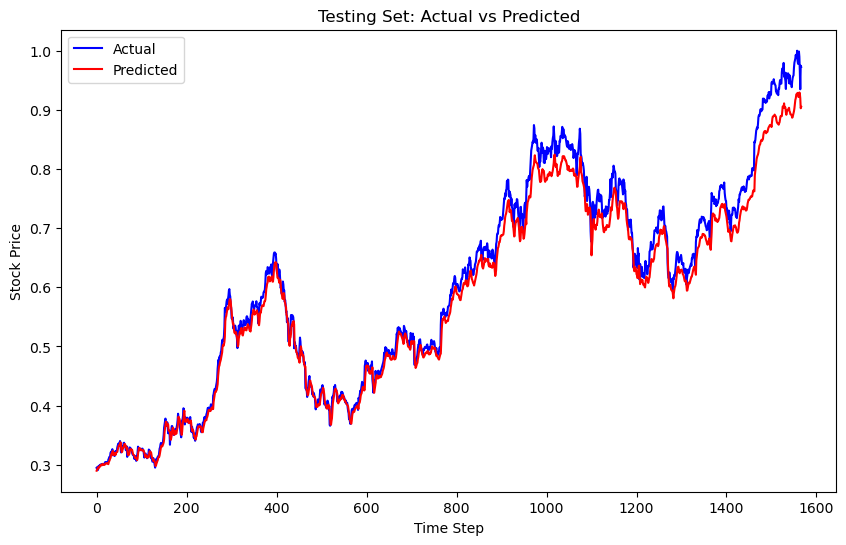

In [23]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, color='blue', label='Actual')
    plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_results(y_test, predicted_test.flatten(), title="Testing Set: Actual vs Predicted")

In [48]:
model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
     Dropout(0.2),
     LSTM(50, return_sequences=True),
     Dropout(0.2),
     LSTM(50),
     Dropout(0.2),
     Dense(1)
 ])
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          
    restore_best_weights=True  
)


In [49]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
202/202 [==============================] - 1s 4ms/step - loss: 1.4911e-04 - val_loss: 0.0148
Epoch 2/100
202/202 [==============================] - 1s 6ms/step - loss: 1.4480e-04 - val_loss: 0.0019
Epoch 3/100
202/202 [==============================] - 1s 5ms/step - loss: 1.3682e-04 - val_loss: 8.5975e-04
Epoch 4/100
202/202 [==============================] - 1s 4ms/step - loss: 1.3606e-04 - val_loss: 0.0014
Epoch 5/100
202/202 [==============================] - 1s 7ms/step - loss: 1.4806e-04 - val_loss: 0.0020
Epoch 6/100
202/202 [==============================] - 1s 5ms/step - loss: 1.3405e-04 - val_loss: 9.6159e-04
Epoch 7/100
202/202 [==============================] - 1s 5ms/step - loss: 1.2605e-04 - val_loss: 0.0012
Epoch 8/100
202/202 [==============================] - 1s 5ms/step - loss: 1.2055e-04 - val_loss: 0.0036


In [46]:
predicted_test = model.predict(X_test)

49/49 [==============================] - 0s 1ms/step


In [47]:
test_mse = mean_squared_error(y_test, predicted_test)
print(f"Testing MSE: {test_mse:.4f}")
test_r2 = r2_score(y_test, predicted_test)
print(f"Testing R2: {test_r2:.4f}")

Testing MSE: 0.0011
Testing R2: 0.9669


In [53]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, color='blue', label='Actual')
    plt.plot(y_pred, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

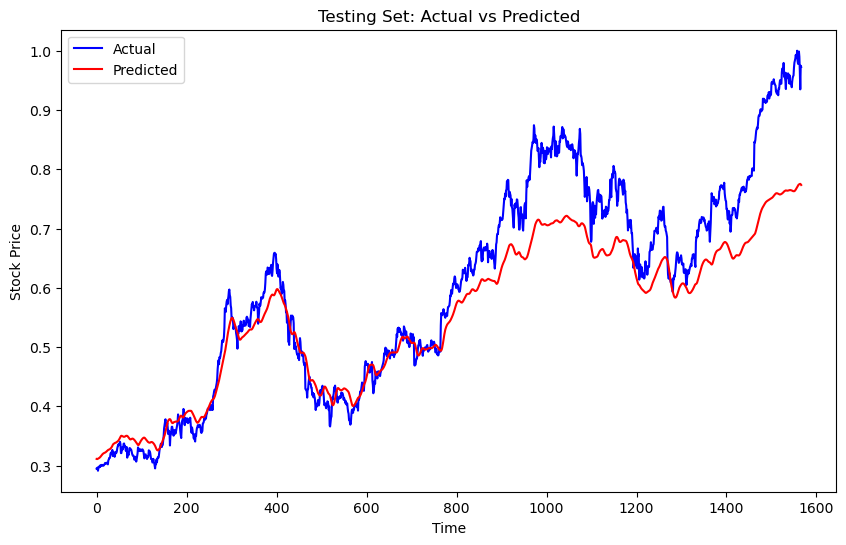

In [54]:
plot_results(y_test, predicted_test.flatten(), title="Testing Set: Actual vs Predicted")

In [29]:
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(50)),
    Dropout(0.3),
    Dense(1)
])

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
202/202 [==============================] - 29s 95ms/step - loss: 8.3765e-05 - val_loss: 0.0014
Epoch 2/100
202/202 [==============================] - 17s 85ms/step - loss: 4.8332e-05 - val_loss: 0.0061
Epoch 3/100
202/202 [==============================] - 19s 95ms/step - loss: 4.6627e-05 - val_loss: 0.0027
Epoch 4/100
202/202 [==============================] - 19s 94ms/step - loss: 3.3989e-05 - val_loss: 0.0070
Epoch 5/100
202/202 [==============================] - 19s 94ms/step - loss: 3.8060e-05 - val_loss: 0.0037
Epoch 6/100
202/202 [==============================] - 19s 94ms/step - loss: 3.5821e-05 - val_loss: 0.0013
Epoch 7/100
202/202 [==============================] - 19s 93ms/step - loss: 3.3401e-05 - val_loss: 0.0012
Epoch 8/100
202/202 [==============================] - 19s 93ms/step - loss: 3.0484e-05 - val_loss: 0.0034
Epoch 9/100
202/202 [==============================] - 19s 93ms/step - loss: 2.9364e-05 - val_loss: 0.0148
Epoch 10/100
202/202 [===============

In [34]:
predicted_test = model.predict(X_test)

49/49 [==============================] - 3s 19ms/step


In [35]:
test_mse = mean_squared_error(y_test, predicted_test)
test_mae = mean_absolute_error(y_test, predicted_test)
test_r2 = r2_score(y_test, predicted_test)

print(f"Testing MSE: {test_mse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing R^2: {test_r2:.4f}")

Testing MSE: 0.0012
Testing MAE: 0.0258
Testing R^2: 0.9630


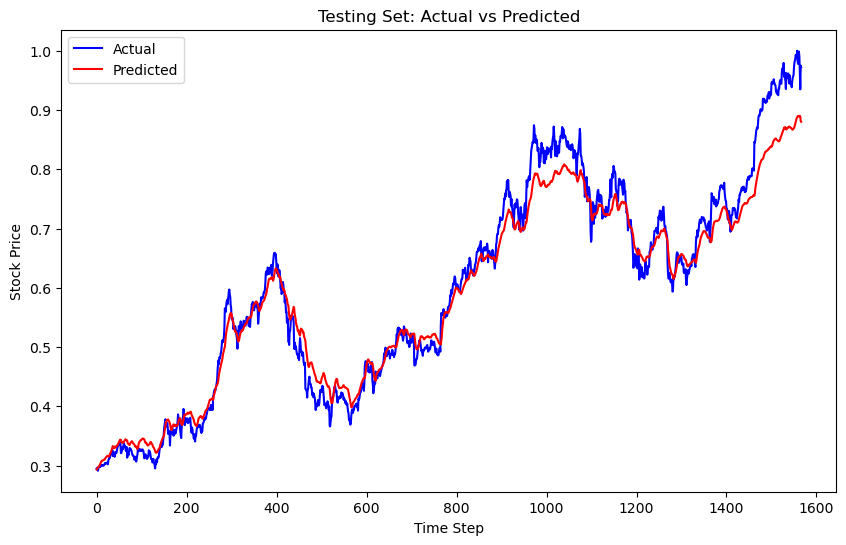

In [36]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, color='blue', label='Actual')
    plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

plot_results(y_test, predicted_test.flatten(), title="Testing Set: Actual vs Predicted")

In [38]:
# model = Sequential([
#     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])),
#     MaxPooling1D(pool_size=2),
#     Dropout(0.3),
#     Flatten(),
#     Dense(50, activation='relu'),
#     Dropout(0.3),
#     Dense(1)
# ])

In [59]:
model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(time_steps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    LSTM(64, return_sequences=False),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1)
])


In [69]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          
    restore_best_weights=True  
)

In [70]:
model.compile(optimizer='adam', loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
202/202 [==============================] - 12s 43ms/step - loss: 6.8861e-05 - val_loss: 0.0164 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - 8s 40ms/step - loss: 7.0931e-05 - val_loss: 0.0163 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - 9s 43ms/step - loss: 6.6844e-05 - val_loss: 0.0246 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - 7s 37ms/step - loss: 6.0755e-05 - val_loss: 0.0095 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - 8s 38ms/step - loss: 5.5264e-05 - val_loss: 0.0107 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - 8s 39ms/step - loss: 5.7109e-05 - val_loss: 0.0165 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - 8s 41ms/step - loss: 4.8499e-05 - val_loss: 0.0022 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - 7s 36ms/step - loss: 5.6754e-05 - val_loss: 0.0077 - lr: 0.0010
Epoch 9/100
202/202 [==========================

In [71]:
predicted_test = model.predict(X_test)

49/49 [==============================] - 1s 7ms/step


In [72]:
test_mse = mean_squared_error(y_test, predicted_test)
test_mae = mean_absolute_error(y_test, predicted_test)
test_r2 = r2_score(y_test, predicted_test)

print(f"Testing MSE: {test_mse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing R^2: {test_r2:.4f}")

Testing MSE: 0.0022
Testing MAE: 0.0350
Testing R^2: 0.9321


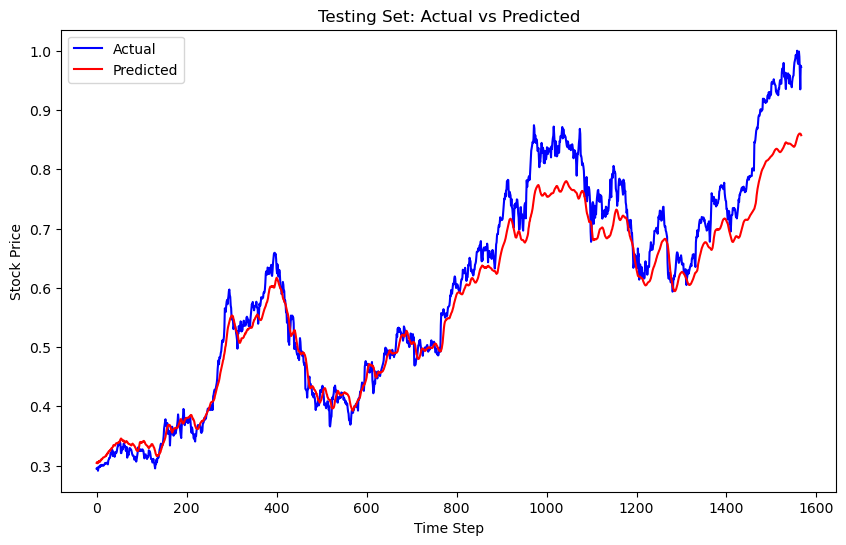

In [73]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, color='blue', label='Actual')
    plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

plot_results(y_test, predicted_test.flatten(), title="Testing Set: Actual vs Predicted")